# Flight price analysis

This notebook is used to analyze the flight prices dataset. The dataset contains information about flights, including the price, departure and arrival times, and other relevant features. The goal of this analysis is to understand the factors that influence flight prices and get insights for the creation of pipelines to process the data.

## Setup: Importing libraries and dataset

To the analysis, we will use the following libraries. Make sure to install them before running the notebook.

In [ ]:
!pip install kaggle numpy matplotlib seaborn pandas

> **Note**: The Kaggle API is used to download the dataset. Make sure to set up your Kaggle API credentials before running the next cell. You can find instructions on how to do this [here](https://github.com/Kaggle/kaggle-api/blob/main/docs/README.md#api-credentials).

In [2]:
import kaggle
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Now we can download the dataset from Kaggle. The dataset is stored in the `/datasets` directory. If the dataset is not found, it will be downloaded from Kaggle executing the next cell. Also, you can download the dataset from [here](https://www.kaggle.com/datasets/dilwong/flightprices).

> **Note**: The dataset is quite large (5 GB zipped, 30 GB unzipped), so it may take some time to download. Make sure you have enough disk space before running the next cell.

In [3]:
if not os.path.exists('../../../datasets/itineraries.csv'):
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files("dilwong/flightprices", path='../../../datasets', unzip=True)

## Exploring the dataset

The dataset used in this project is the [Flight Prices](https://www.kaggle.com/datasets/dilwong/flightprices) dataset from Kaggle. It contains information about flights, including the price, departure and arrival times, and other relevant features. The dataset is stored in a CSV file named `itineraries.csv`.

In [4]:
path = '../../../datasets/itineraries.csv'

The dataset contains the following columns:
- **legId**: An identifier for the flight.
- **searchDate**: The date (`YYYY-MM-DD`) on which this entry was taken from Expedia.
- **flightDate**: The date (`YYYY-MM-DD`) of the flight.
- **startingAirport**: Three-character IATA airport code for the initial location.
- **destinationAirport**: Three-character IATA airport code for the arrival location.
- **fareBasisCode**: The fare basis code.
- **travelDuration**: The travel duration in hours and minutes.
- **elapsedDays**: The number of elapsed days (usually 0).
- **isBasicEconomy**: Boolean indicating whether the ticket is for basic economy.
- **isRefundable**: Boolean indicating whether the ticket is refundable.
- **isNonStop**: Boolean indicating whether the flight is non-stop.
- **baseFare**: The price of the ticket (in USD).
- **totalFare**: The price of the ticket (in USD) including taxes and other fees.
- **seatsRemaining**: Integer indicating the number of seats remaining.
- **totalTravelDistance**: The total travel distance in miles. This data is sometimes missing.
- **segmentsDepartureTimeEpochSeconds**: String containing the departure time (Unix time) for each leg of the trip, separated by `||`.
- **segmentsDepartureTimeRaw**: String containing the departure time (ISO 8601 format: `YYYY-MM-DDThh:mm:ss.000±[hh]:00`) for each leg of the trip, separated by `||`.
- **segmentsArrivalTimeEpochSeconds**: String containing the arrival time (Unix time) for each leg of the trip, separated by `||`.
- **segmentsArrivalTimeRaw**: String containing the arrival time (ISO 8601 format: `YYYY-MM-DDThh:mm:ss.000±[hh]:00`) for each leg of the trip, separated by `||`.
- **segmentsArrivalAirportCode**: String containing the IATA airport code for the arrival location for each leg of the trip, separated by `||`.
- **segmentsDepartureAirportCode**: String containing the IATA airport code for the departure location for each leg of the trip, separated by `||`.
- **segmentsAirlineName**: String containing the name of the airline that services each leg of the trip, separated by `||`.
- **segmentsAirlineCode**: String containing the two-letter airline code that services each leg of the trip, separated by `||`.
- **segmentsEquipmentDescription**: String containing the type of airplane used for each leg of the trip (e.g., "Airbus A321" or "Boeing 737-800"), separated by `||`.
- **segmentsDurationInSeconds**: String containing the duration of the flight (in seconds) for each leg of the trip, separated by `||`.
- **segmentsDistance**: String containing the distance traveled (in miles) for each leg of the trip, separated by `||`.
- **segmentsCabinCode**: String containing the cabin class for each leg of the trip (e.g., "coach"), separated by `||`.


In [5]:
# Read only first few rows
df_head = pd.read_csv(path, nrows=10)
print(df_head.dtypes)

legId                                 object
searchDate                            object
flightDate                            object
startingAirport                       object
destinationAirport                    object
fareBasisCode                         object
travelDuration                        object
elapsedDays                            int64
isBasicEconomy                          bool
isRefundable                            bool
isNonStop                               bool
baseFare                             float64
totalFare                            float64
seatsRemaining                         int64
totalTravelDistance                    int64
segmentsDepartureTimeEpochSeconds     object
segmentsDepartureTimeRaw              object
segmentsArrivalTimeEpochSeconds       object
segmentsArrivalTimeRaw                object
segmentsArrivalAirportCode            object
segmentsDepartureAirportCode          object
segmentsAirlineName                   object
segmentsAi

For the analysis and the proposed jobs on this project, we will focus on the following columns:
- **flightDate**: The date of the flight in `YYYY-MM-DD` format.
- **startingAirport**: The airport where the flight starts.
- **destinationAirport**: The airport where the flight ends.
- **travelDuration**: The total travel duration in hours and minutes.
- **isNonStop**: A boolean indicating whether the flight is non-stop.
- **totalFare**: The total fare of the flight, including taxes and fees.

In the next cell, we will read the dataset and filter the columns we want to use for the analysis.

In [6]:
cols_to_use = ['searchDate', 'flightDate', 'startingAirport', 'destinationAirport', 'travelDuration', 'isNonStop', 'totalFare']
df_filtered = pd.read_csv(path, usecols=cols_to_use)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82138753 entries, 0 to 82138752
Data columns (total 7 columns):
 #   Column              Dtype  
---  ------              -----  
 0   searchDate          object 
 1   flightDate          object 
 2   startingAirport     object 
 3   destinationAirport  object 
 4   travelDuration      object 
 5   isNonStop           bool   
 6   totalFare           float64
dtypes: bool(1), float64(1), object(5)
memory usage: 3.7+ GB


We fix any inconsistencies in the dataset, such as data types and missing values.

In [7]:
df_filtered['searchDate'] = pd.to_datetime(df_filtered['searchDate'], format='%Y-%m-%d', errors='coerce')
df_filtered['flightDate'] = pd.to_datetime(df_filtered['flightDate'], format='%Y-%m-%d', errors='coerce')
df_filtered['startingAirport'] = df_filtered['startingAirport'].astype('string')
df_filtered['destinationAirport'] = df_filtered['destinationAirport'].astype('string')

# We convert the `travelDuration` column from ISO 8601 format to a numeric format (total minutes).
import re

def parse_iso_duration(duration_str):
    if pd.isna(duration_str):
        return None
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?', duration_str)
    if not match:
        return None
    hours = int(match.group(1)) if match.group(1) else 0
    minutes = int(match.group(2)) if match.group(2) else 0
    return hours * 60 + minutes

df_filtered['travelDuration'] = df_filtered['travelDuration'].apply(parse_iso_duration)

Since this dataset is quite large, we will drop any rows with missing values in the columns we are interested in. This will help us to avoid issues with the analysis later on.

In [8]:
print("Empty cells count:\n")
print(df_filtered.isnull().sum())

if df_filtered.isnull().sum().any():
    print("\nThere are empty cells in the dataset. We will drop them.")
    df_filtered = df_filtered.dropna()
else:
    print("\nNo empty cells found.")

Empty cells count:

searchDate                0
flightDate                0
startingAirport           0
destinationAirport        0
travelDuration        31596
isNonStop                 0
totalFare                 0
dtype: int64

There are empty cells in the dataset. We will drop them.


Now we can check the data types of the columns and ensure they are correct for our analysis.

In [9]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82107157 entries, 0 to 82138752
Data columns (total 7 columns):
 #   Column              Dtype         
---  ------              -----         
 0   searchDate          datetime64[ns]
 1   flightDate          datetime64[ns]
 2   startingAirport     string        
 3   destinationAirport  string        
 4   travelDuration      float64       
 5   isNonStop           bool          
 6   totalFare           float64       
dtypes: bool(1), datetime64[ns](2), float64(2), string(2)
memory usage: 4.4 GB


## Data exploration and data cleaning

After filtering the dataset with proper columns and data type, we will check the descriptive statistics of the dataset. This will help us to understand the distribution of the data and identify any potential outliers or anomalies.

In [10]:
df_filtered.describe()

,searchDate,flightDate,travelDuration,totalFare
count,82107157,82107157,8.210716e+07,8.210716e+07
mean,2022-07-13 19:59:27.979184896,2022-08-09 17:35:16.784685312,4.278850e+02,3.402953e+02
min,2022-04-16 00:00:00,2022-04-17 00:00:00,0.000000e+00,1.959000e+01
25%,2022-06-05 00:00:00,2022-07-02 00:00:00,2.620000e+02,1.971000e+02
50%,2022-07-15 00:00:00,2022-08-14 00:00:00,4.090000e+02,3.051100e+02
75%,2022-08-23 00:00:00,2022-09-18 00:00:00,5.660000e+02,4.516100e+02
max,2022-10-05 00:00:00,2022-11-19 00:00:00,1.439000e+03,8.260610e+03
std,NaN,NaN,2.241082e+02,1.959597e+02


The only anomaly we can see in the dataset is the `travelDuration` column, which has a minimum value of 0. This means that there are some flights with no travel duration, which is not possible (at least for the jobs that we are interested). We will drop these rows from the dataset.

In [11]:
df_filtered = df_filtered[df_filtered['travelDuration'] != 0]
df_filtered.reset_index(drop=True, inplace=True)
df_filtered.describe()

,searchDate,flightDate,travelDuration,totalFare
count,82107153,82107153,8.210715e+07,8.210715e+07
mean,2022-07-13 19:59:27.919553792,2022-08-09 17:35:16.659382528,4.278850e+02,3.402953e+02
min,2022-04-16 00:00:00,2022-04-17 00:00:00,3.400000e+01,1.959000e+01
25%,2022-06-05 00:00:00,2022-07-02 00:00:00,2.620000e+02,1.971000e+02
50%,2022-07-15 00:00:00,2022-08-14 00:00:00,4.090000e+02,3.051100e+02
75%,2022-08-23 00:00:00,2022-09-18 00:00:00,5.660000e+02,4.516100e+02
max,2022-10-05 00:00:00,2022-11-19 00:00:00,1.439000e+03,8.260610e+03
std,NaN,NaN,2.241082e+02,1.959597e+02



### Data visualization

Because of the size of the dataset, we will take a sample of 10,000 rows to visualize the data. This will help us to understand the distribution of the data and identify any potential outliers or anomalies without overwhelming our visualizations.

In [12]:
sample_filtered = df_filtered.sample(n=10000, random_state=42)

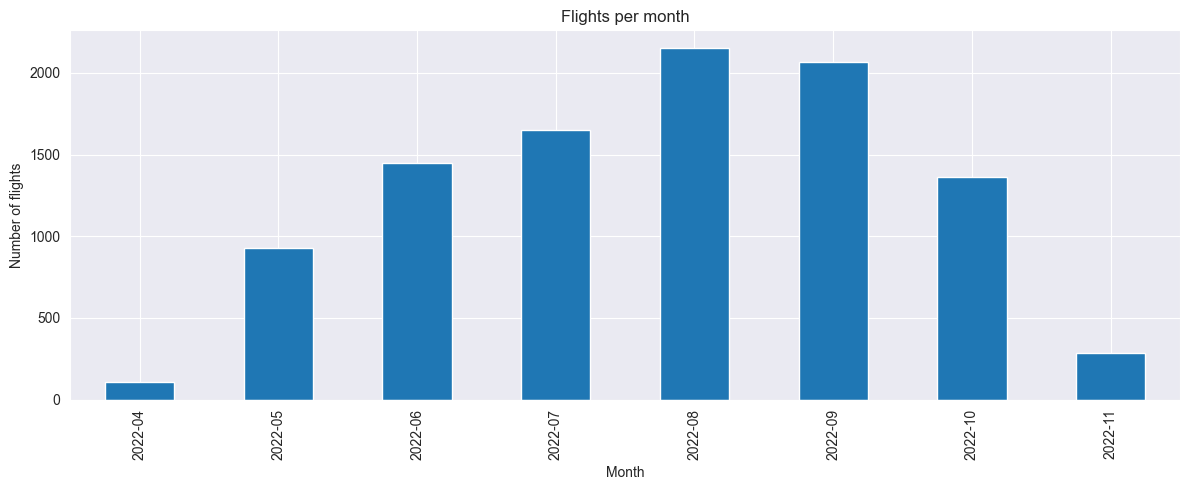

In [13]:
monthly_counts = sample_filtered.groupby(sample_filtered['flightDate'].dt.to_period('M')).size()

plt.figure(figsize=(12, 5))
monthly_counts.sort_index().plot(kind='bar')
plt.title('Flights per month')
plt.xlabel('Month')
plt.ylabel('Number of flights')
plt.tight_layout()
plt.show()

As we can see, the number of flights is quite consistent over the months, with a slight increase in the summer months. This is expected, as more people tend to travel during the summer holidays.

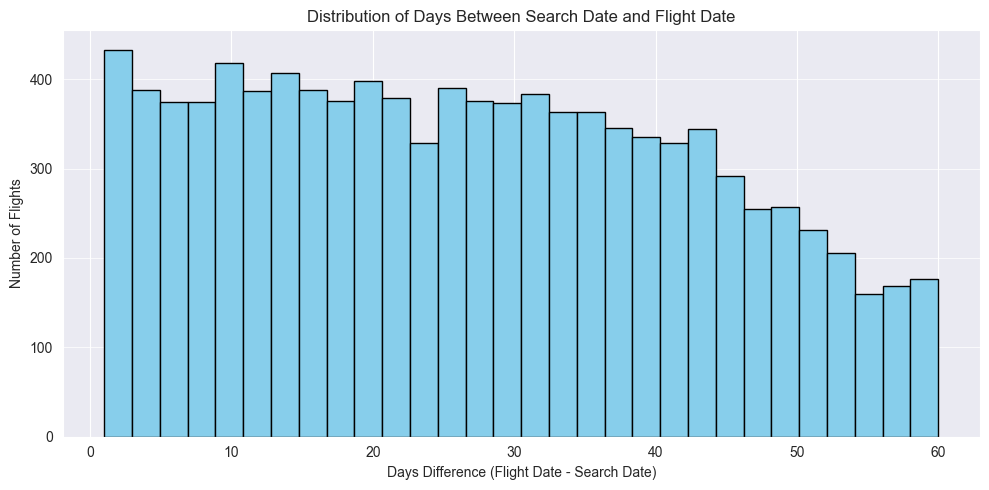

In [14]:
sample_filtered['days_diff'] = (sample_filtered['flightDate'] - sample_filtered['searchDate']).dt.days

plt.figure(figsize=(10,5))
plt.hist(sample_filtered['days_diff'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Days Between Search Date and Flight Date')
plt.xlabel('Days Difference (Flight Date - Search Date)')
plt.ylabel('Number of Flights')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

As we can see, most flights are booked within 30 days of the flight date. This is expected, as most people tend to book their flights closer to the travel date. However, the graph is mostly well distributed, with the mayority of flights booked within 60 days of the flight date.

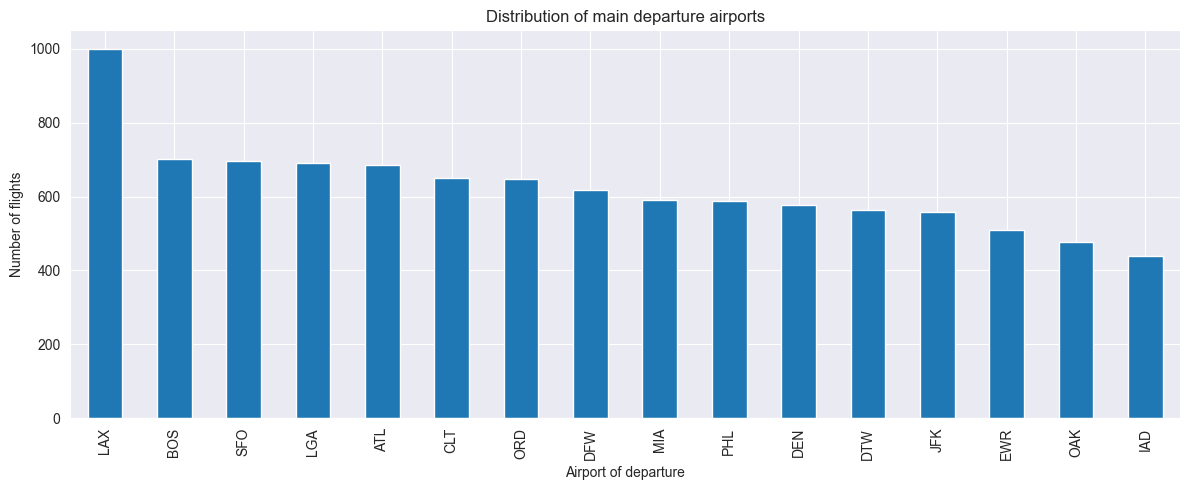

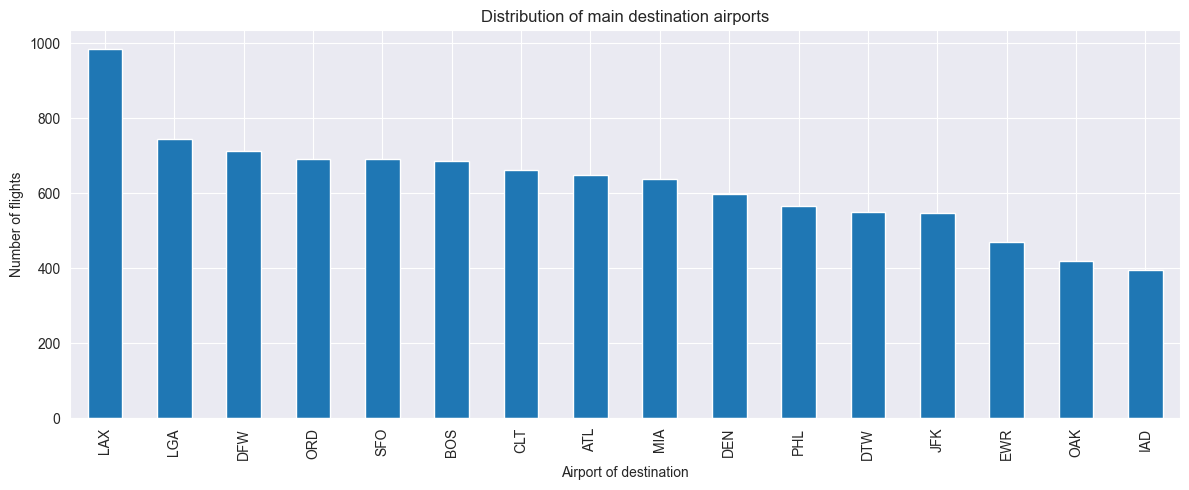

In [15]:
# Distribution of departure airports
plt.figure(figsize=(12, 5))
sample_filtered['startingAirport'].value_counts().head(20).plot(kind='bar')
plt.title('Distribution of main departure airports')
plt.xlabel('Airport of departure')
plt.ylabel('Number of flights')
plt.tight_layout()
plt.show()

# Distribution of main destination airports
plt.figure(figsize=(12, 5))
sample_filtered['destinationAirport'].value_counts().head(20).plot(kind='bar')
plt.title('Distribution of main destination airports')
plt.xlabel('Airport of destination')
plt.ylabel('Number of flights')
plt.tight_layout()
plt.show()

The distribution of departure and destination airports shows that the most common airport is LAX (Los Angeles International Airport). Meanwhile, the other airports share a similar number of flights, with a few exceptions. This is expected, as LAX is one of the busiest airports in the world and serves as a major hub for many airlines.

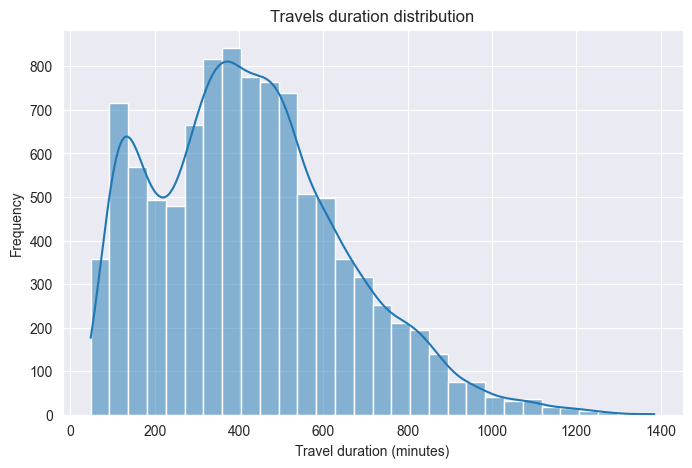

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(sample_filtered['travelDuration'], bins=30, kde=True)
plt.title('Travels duration distribution')
plt.xlabel('Travel duration (minutes)')
plt.ylabel('Frequency')
plt.show()

The distribution of travel duration shows that most flights have a travel duration of less than 300 minutes (5 hours). There are some outliers with longer travel durations, but they are not very common. This is expected, as most flights are short to medium-haul flights.

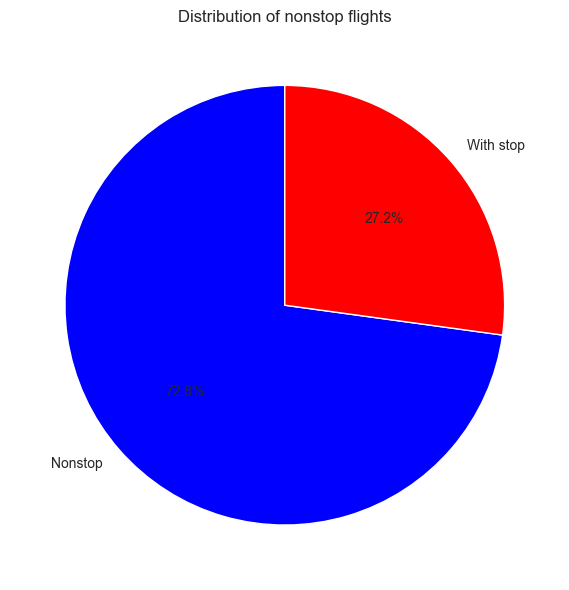

In [17]:
nonstop_counts = sample_filtered['isNonStop'].value_counts()

plt.figure(figsize=(6, 6))
nonstop_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, labels=['Nonstop', 'With stop'], colors=['blue', 'red'])
plt.title('Distribution of nonstop flights')
plt.ylabel('')
plt.tight_layout()
plt.show()

Most of the flights in the sample are non-stop flights, which is expected as many airlines offer non-stop flights for popular routes. However, there are still a significant number of flights with stops, which can be due to various reasons such as cost, availability, or flight schedules.

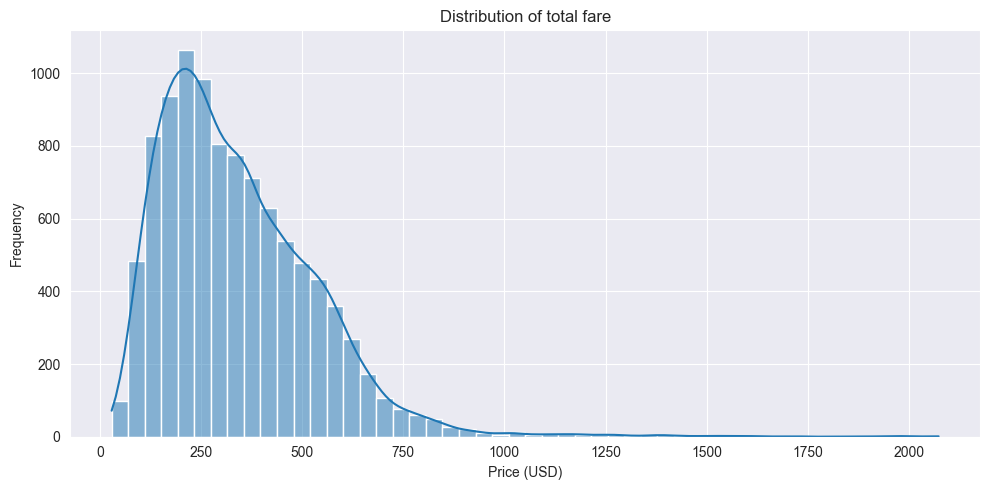

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(sample_filtered['totalFare'], bins=50, kde=True)
plt.title('Distribution of total fare')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The price distribution of flights shows that most flights have a total fare of less than $500. There are some outliers with higher fares, but they are not very common.

### Correlation analysis

To understand the relationships between the variables in the dataset, we will calculate the correlation matrix. This will help us to identify any potential correlations between the variables and understand how they are related to each other.

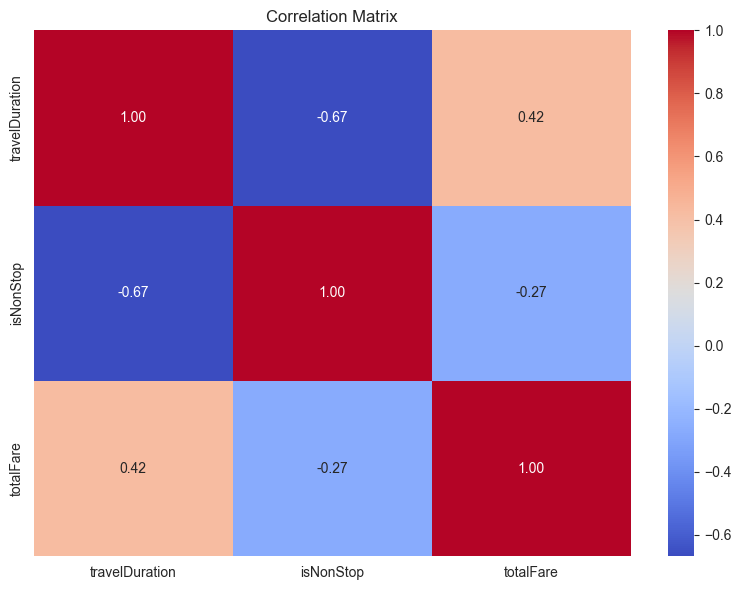

In [24]:
corr_matrix = sample_filtered[['travelDuration', 'isNonStop', 'totalFare']].corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

As we can see in the correlation matrix, the `totalFare` column has a strong positive correlation with the `travelDuration` column, which means that longer flights tend to be more expensive. The `isNonStop` column also has a positive correlation with the `totalFare` column, indicating that non-stop flights tend to be more expensive than flights with stops.

## Exporting a sample of the dataset

In [20]:
fraction_of_sample = 0.03  # 1% of the dataset

path_to_export_sample = '../../../datasets/itineraries_sample.csv'
dataset_sample_size = int(df_filtered.shape[0]*fraction_of_sample)

In [ ]:
if os.path.exists(path_to_export_sample):
    print(f"File {path_to_export_sample} already exists.")
else:
    print(f"Exporting a sample of the dataset to {path_to_export_sample}...")
    filename = path
    with open(filename, "r") as f:
        total_lines = sum(1 for line in f) - 1  # subtract 1 for header
    skip = sorted(random.sample(range(1, total_lines + 1), total_lines - dataset_sample_size))
    df_original_sample = pd.read_csv(filename, skiprows=skip)
    df_original_sample.to_csv(path_to_export_sample, index=False)
    print(f"Sample dataset exported to {path_to_export_sample}.")

## Exporting the cleaned dataset (Optional)

> **Note**: Execute the next cell only if you want to export the cleaned dataset to a CSV file.

In [22]:
path_to_export_cleaned = '../../../datasets/cleaned_flight_prices.csv'

In [ ]:
if os.path.exists(path_to_export_cleaned):
    print(f"File {path_to_export_cleaned} already exists.")
else:
    print(f"Exporting dataset to {path_to_export_cleaned}...")
    df_filtered.to_csv(path_to_export_cleaned, index=False)
    print(f"Dataset exported.")